<a href="https://colab.research.google.com/github/dnevo/Practicum/blob/master/S13_Time_Series_taxi_orders_in_next_hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Descrition
Sweet Lift Taxi company has collected historical data on taxi orders at
airports. To attract more drivers during peak hours, we need to predict the
amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.
##Project instructions
1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample
should be 10% of the initial dataset.
4. Test the data using the test sample and provide a conclusion.

## Data description
The data is stored in the /datasets/taxi.csv file. Download the dataset.
The number of orders is in the num_orders column.

## Project evaluation
- How did you prepare the data?
- What models and hyperparameters have you considered?
- Have you managed to avoid code duplication?
- What are your findings?
- Have you kept to the project structure?
- Have you kept the code neat?


In [1]:
colab = True
if colab:
    data_path = 'https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/taxi.csv'
else:
    data_path = '/datasets/taxi.csv'

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format

# 1. Data download and Resampling (1H)

In [3]:
data = pd.read_csv(data_path, index_col=[0],  parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


#2. Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


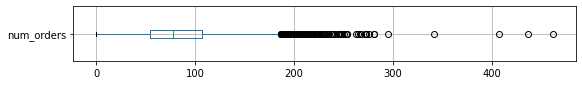

In [4]:
print(data.info())
data.boxplot(vert=False, figsize=(9,1));

As above, the data consists of hourly number of orders for the period 1/3/2018 to 31/8/2018. The majority number of orders is below 200 per hour, with few peaks above 300.

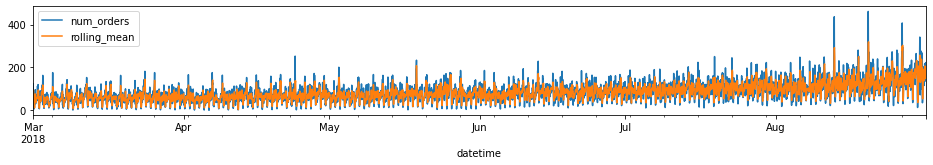

In [5]:
data1 = data.copy()
data1['rolling_mean'] = data1.rolling(3).mean()
data1.plot(figsize=(16, 2));

We can notice a trend of growth of during the whole period of 8 months. There are peaks above 300 in August - let's focus on them, by zooming on August:

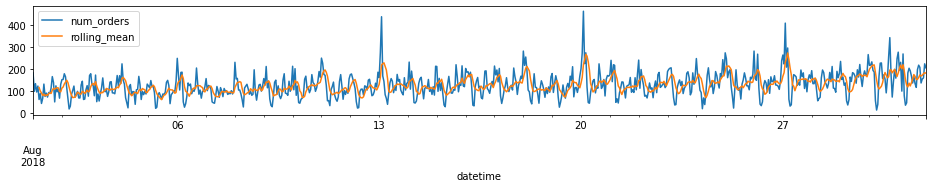

In [6]:
data1 = data['2018-08-01':'2018-08-31'].copy()
data1['rolling_mean'] = data1.rolling(6).mean()
data1.plot(figsize=(16, 2));

The peaks occur in the last 3 weekends (00:00 - 01:00 on the nights between Sunday and Monday.

Let's proceed by deeper looking on last week of August:

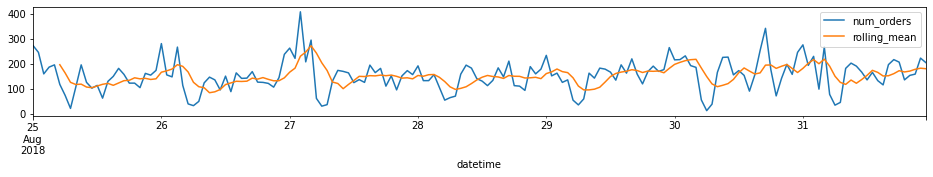

In [7]:
data1 = data['2018-08-25':'2018-08-31'].copy()
data1['rolling_mean'] = data1.rolling(6).mean()
data1.plot(figsize=(16, 2));

We can notice that the daily low frequency occurs in early mornings (05:00 - 07:00), with high frequencies in the evenings and top frequencies in the night ending weekends, as already mentioned.

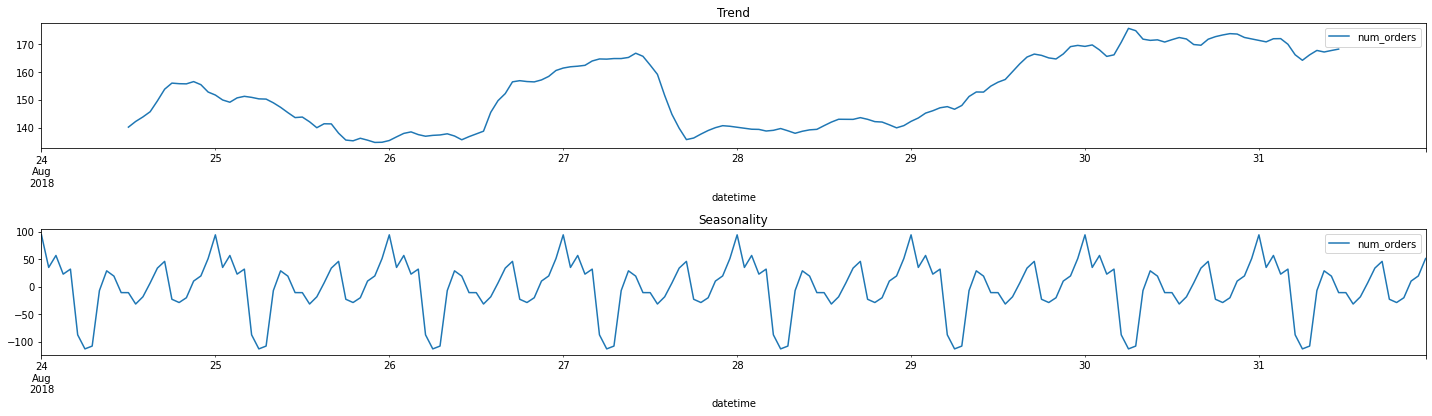

In [8]:
decomposed = seasonal_decompose(data['2018-08-24':'2018-08-31'])
plt.figure(figsize=(20, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Same as stated before, is dispayed above using decomposition.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

def prepare_train_test(max_lag, rolling_mean_size):
    df = data.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train = train.dropna()
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test['num_orders'] 
    return features_train, target_train, features_test, target_test

In [10]:
def eval_model (model_type, max_lag, rolling_mean_size):
    features_train, target_train, features_test, target_test = prepare_train_test(max_lag, rolling_mean_size)
    model = model_type()
    model.fit(features_train, target_train)
    print(f'{model_type.__name__},max_lag:{max_lag},'\
          f'rolling_mean_size:{rolling_mean_size},'\
          f'RMSE train: {sqrt(mean_squared_error(target_train, model.predict(features_train))):.1f},'\
          f'RMSE test: {sqrt(mean_squared_error(target_test, model.predict(features_test))):.1f}')

for max_lag in range(150,301, 10):
    eval_model(LinearRegression, max_lag, 10)

LinearRegression,max_lag:150,rolling_mean_size:10,RMSE train: 21.6,RMSE test: 40.5
LinearRegression,max_lag:160,rolling_mean_size:10,RMSE train: 21.5,RMSE test: 39.9
LinearRegression,max_lag:170,rolling_mean_size:10,RMSE train: 20.3,RMSE test: 35.7
LinearRegression,max_lag:180,rolling_mean_size:10,RMSE train: 20.2,RMSE test: 35.8
LinearRegression,max_lag:190,rolling_mean_size:10,RMSE train: 20.2,RMSE test: 35.8
LinearRegression,max_lag:200,rolling_mean_size:10,RMSE train: 20.1,RMSE test: 35.6
LinearRegression,max_lag:210,rolling_mean_size:10,RMSE train: 20.1,RMSE test: 35.7
LinearRegression,max_lag:220,rolling_mean_size:10,RMSE train: 20.0,RMSE test: 35.6
LinearRegression,max_lag:230,rolling_mean_size:10,RMSE train: 20.0,RMSE test: 35.7
LinearRegression,max_lag:240,rolling_mean_size:10,RMSE train: 20.0,RMSE test: 35.7
LinearRegression,max_lag:250,rolling_mean_size:10,RMSE train: 20.0,RMSE test: 35.7
LinearRegression,max_lag:260,rolling_mean_size:10,RMSE train: 20.0,RMSE test: 36.0
Line

In [11]:
features_train, target_train, features_test, target_test = prepare_train_test(max_lag=200, rolling_mean_size=10)
model = RandomForestRegressor(random_state=12345, max_depth=20)
model.fit(features_train, target_train)
print(f'RMSE train: {sqrt(mean_squared_error(target_train, model.predict(features_train))):.1f},'\
        f'RMSE test: {sqrt(mean_squared_error(target_test, model.predict(features_test))):.1f}')

RMSE train: 8.1,RMSE test: 38.7


In [ ]:
TODO: add plot of target_train and target_test

In [12]:
features_train, target_train, features_test, target_test = prepare_train_test(max_lag=200, rolling_mean_size=10)
model = RandomForestRegressor(random_state=12345, max_depth=7)
model.fit(features_train, target_train)
print(f'RMSE train: {sqrt(mean_squared_error(target_train, model.predict(features_train))):.1f},'\
        f'RMSE test: {sqrt(mean_squared_error(target_test, model.predict(features_test))):.1f}')

RMSE train: 16.5,RMSE test: 39.4


In [13]:
features_train, target_train, features_test, target_test = prepare_train_test(max_lag=200, rolling_mean_size=10)
model = RandomForestRegressor(random_state=12345, max_depth=6)
model.fit(features_train, target_train)
print(f'RMSE train: {sqrt(mean_squared_error(target_train, model.predict(features_train))):.1f},'\
        f'RMSE test: {sqrt(mean_squared_error(target_test, model.predict(features_test))):.1f}')

RMSE train: 18.1,RMSE test: 39.8


In [14]:
features_train, target_train, features_test, target_test = prepare_train_test(max_lag=200, rolling_mean_size=10)
nleaves = 30
params = {
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': {'root_mean_squared_error'},
 'num_leaves': nleaves,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'verbose': 0
}
lgb_train = lgbm.Dataset(features_train, target_train)
lgb_test = lgbm.Dataset(features_test, target_test, reference=lgb_train)
gbm = lgbm.train(params,
                lgb_train,
                num_boost_round=800,
                valid_sets=lgb_test,
                early_stopping_rounds=5,verbose_eval=100)

prediction_train = gbm.predict(features_train, num_iteration=gbm.best_iteration)
prediction_test = gbm.predict(features_test, num_iteration=gbm.best_iteration)
print(f'RMSE train: {sqrt(mean_squared_error(target_train, prediction_train)):.1f},'\
        f'RMSE test: {sqrt(mean_squared_error(target_test, prediction_test)):.1f}')

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[93]	valid_0's rmse: 36.5351
RMSE train: 13.6,RMSE test: 36.5


In [15]:
features_train, target_train, features_test, target_test = prepare_train_test(max_lag=200, rolling_mean_size=10)
nleaves = 17
params = {
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': {'root_mean_squared_error'},
 'num_leaves': nleaves,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'verbose': 0
}
lgb_train = lgbm.Dataset(features_train, target_train)
lgb_test = lgbm.Dataset(features_test, target_test, reference=lgb_train)
gbm = lgbm.train(params,
                lgb_train,
                num_boost_round=800,
                valid_sets=lgb_test,
                early_stopping_rounds=5,verbose_eval=100)

prediction_train = gbm.predict(features_train, num_iteration=gbm.best_iteration)
prediction_test = gbm.predict(features_test, num_iteration=gbm.best_iteration)
print(f'RMSE train: {sqrt(mean_squared_error(target_train, prediction_train)):.1f},'\
        f'RMSE test: {sqrt(mean_squared_error(target_test, prediction_test)):.1f}')

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[90]	valid_0's rmse: 36.8005
RMSE train: 16.2,RMSE test: 36.8
